In [1]:
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential,Model,initializers,layers,Input
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import PIL
import PIL.Image

import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
data_dir = r'D:\Coding\DeepLearning\dataset\flowers'
batch_size = 16
img_height = 112
img_width = 112

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 3459 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 864 files for validation.


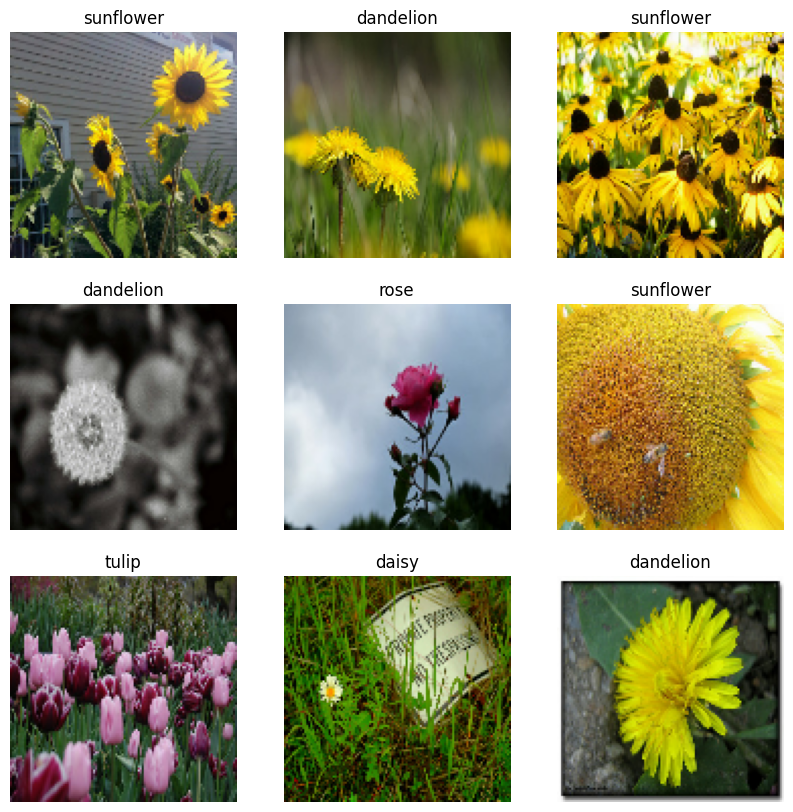

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [10]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
# resizing_layer = tf.keras.layers.experimental.preprocessing.Resizing(img_height, img_width)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# ResNet

### Residual Blocks

In [12]:
def ResidualBlock_original(x, filter_size):
    x1=x
    x1=layers.Conv2D(filters=filter_size,kernel_size=(3,3),strides=(1,1),padding='same')(x1)
    x1=layers.BatchNormalization()(x1)
    x1=layers.ReLU()(x1)
    x1=layers.Conv2D(filters=filter_size,kernel_size=(3,3),strides=(1,1),padding='same')(x1)
    x1=layers.BatchNormalization()(x1)
    x2=layers.Add()([x,x1])
    x2=layers.ReLU()(x2)

    return x2

In [13]:
def ResidualBlock_full_pre_activation(x, filter_size):
    x1=x
    x1=layers.BatchNormalization()(x1)
    x1=layers.ReLU()(x1)
    x1=layers.Conv2D(filters=filter_size,kernel_size=(3,3),strides=(1,1),padding='same')(x1)
    x1=layers.BatchNormalization()(x1)
    x1=layers.ReLU()(x1)
    x1=layers.Conv2D(filters=filter_size,kernel_size=(3,3),strides=(1,1),padding='same')(x1)
    x2=layers.Add()([x,x1])
    
    return x2

### ResNet 34

In [16]:
inputs=Input(shape=(112,112,3))
x=layers.Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),activation='relu',padding='same')(inputs)
x=layers.BatchNormalization()(x)
x=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
x=ResidualBlock_full_pre_activation(x,64)
x=ResidualBlock_full_pre_activation(x,64)
x=ResidualBlock_full_pre_activation(x,64)

x=layers.Conv2D(filters=128,kernel_size=(3,3),strides=(2,2),padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.ReLU()(x)
x=layers.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.ReLU()(x)

x=ResidualBlock_full_pre_activation(x,128)
x=ResidualBlock_full_pre_activation(x,128)
x=ResidualBlock_full_pre_activation(x,128)

x=layers.Conv2D(filters=256,kernel_size=(3,3),strides=(2,2),padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.ReLU()(x)
x=layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.ReLU()(x)

x=ResidualBlock_full_pre_activation(x,256)
x=ResidualBlock_full_pre_activation(x,256)
x=ResidualBlock_full_pre_activation(x,256)
x=ResidualBlock_full_pre_activation(x,256)
x=ResidualBlock_full_pre_activation(x,256)

x=layers.Conv2D(filters=512,kernel_size=(3,3),strides=(2,2),padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.ReLU()(x)
x=layers.Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.ReLU()(x)

x=ResidualBlock_full_pre_activation(x,512)
x=ResidualBlock_full_pre_activation(x,512)

x=layers.GlobalAveragePooling2D()(x)
output=layers.Dense(units=5,activation='softmax')(x)
   
ResNet34 = tf.keras.models.Model(inputs,output)

In [17]:
lr_rate=tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 30000, 0.93, staircase=False, name=None)

In [18]:
ResNet34.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate),
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard

model_checkpoint_best_path=r'./models/ResNet_34/'
model_checkpoint_best=ModelCheckpoint(filepath=model_checkpoint_best_path, monitor='val_accuracy', save_best_only=True, save_weights_only=True, save_freq='epoch')
early_stopping=EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-4)

log_dir=r'./models/log_dir/'
tensorboard_callback=TensorBoard(log_dir=log_dir, histogram_freq=1)

In [20]:
ResNet34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_64 (Conv2D)             (None, 56, 56, 64)   9472        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_64 (BatchN  (None, 56, 56, 64)  256         ['conv2d_64[0][0]']              
 ormalization)                                                                                    
                                                                                              

In [25]:
plot_model(ResNet34,to_file='ResNet34.png',show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


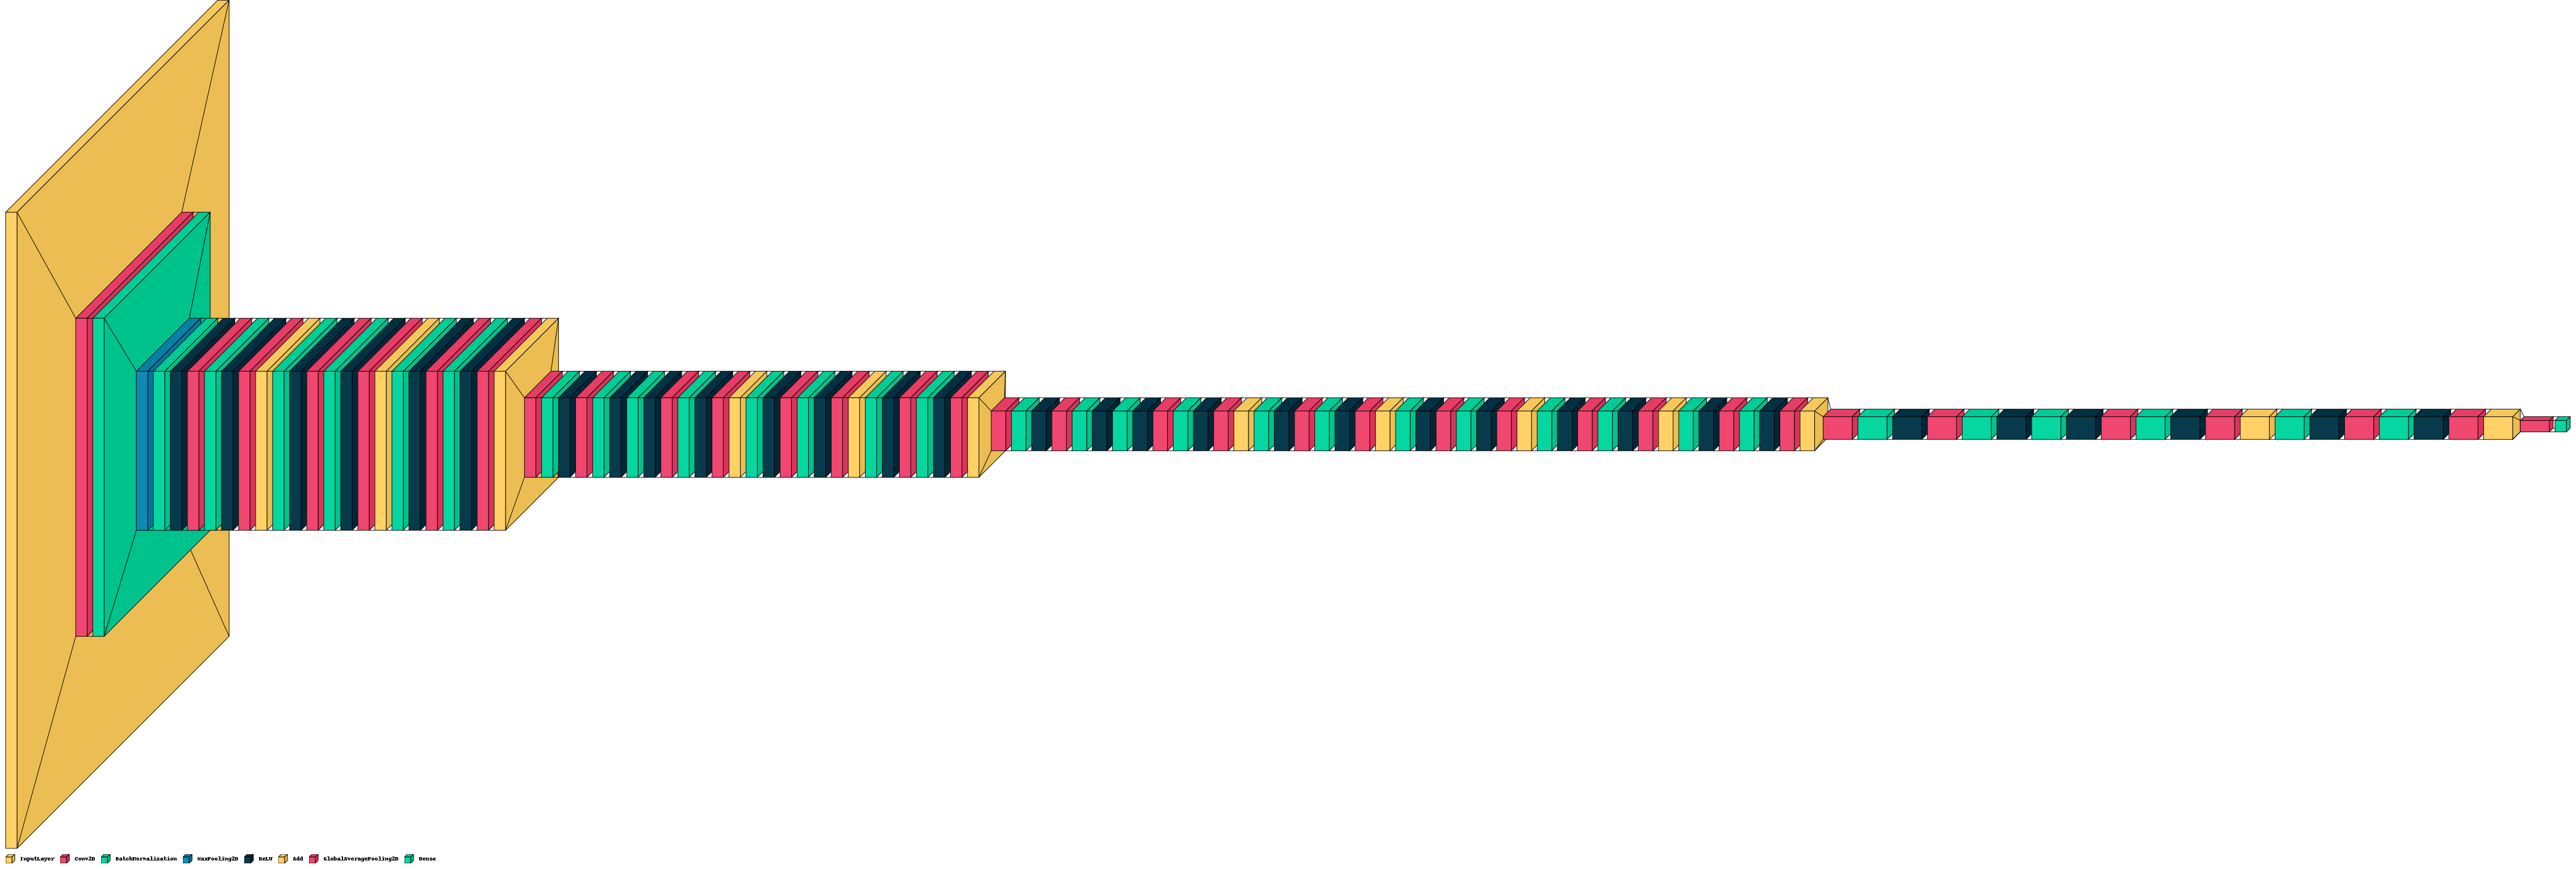

In [26]:
import visualkeras
visualkeras.layered_view(ResNet34, scale_xy=10, legend=True)

In [27]:
hist = ResNet34.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=[model_checkpoint_best, early_stopping, tensorboard_callback], verbose=1)

Epoch 1/3
217/217 [==============================] - 13s 40ms/step - loss: 2.8249 - accuracy: 0.2304 - val_loss: 5.7362 - val_accuracy: 0.1632
Epoch 2/3
217/217 [==============================] - 8s 37ms/step - loss: 1.5941 - accuracy: 0.3012 - val_loss: 1.7295 - val_accuracy: 0.3472
Epoch 3/3
217/217 [==============================] - 8s 37ms/step - loss: 1.3911 - accuracy: 0.3874 - val_loss: 1.8781 - val_accuracy: 0.4282


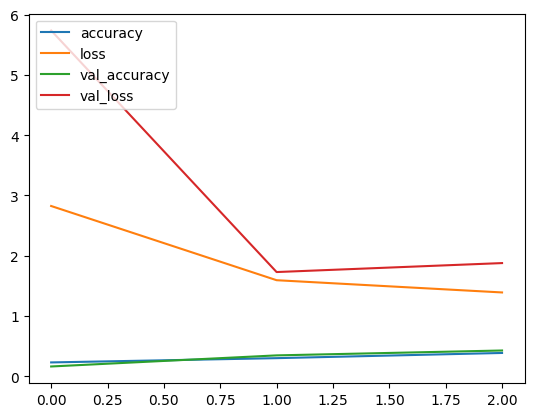

In [28]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [29]:
loss, acc = ResNet34.evaluate(val_ds, verbose=1)
print(loss, acc)

54/54 [==============================] - 1s 11ms/step - loss: 1.8781 - accuracy: 0.4282
1.8781298398971558 0.42824074625968933


In [30]:
ResNet34.save("models/ResNet_001.h5")